## Recursive Neural Networks (RNN)

Una RNN es una clase de redes neuronales artificiales donde las conexiones entre nodos pueden crear un ciclo, lo que permite que la ouput de algunos nodos afecte al input posterior a los mismos nodos.


La principal diferencia es que la red neuronal convencional toma decisiones basadas solo en el input actual, la RNN toma decisiones basadas en los inputs actuales y anteriores.

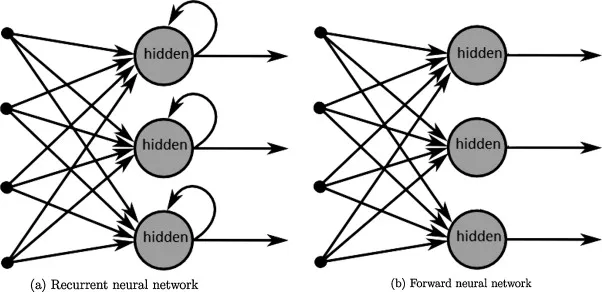

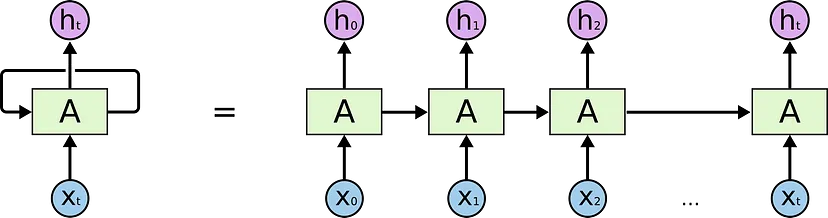

In [1]:
import numpy as np
import pandas as pd

import matplotlib # Para ver la versión
import matplotlib.pyplot as plt

import tensorflow as tf # Para ver la versión
import keras # Para ver la versión

from keras.layers import Input, SimpleRNN, Dense, Flatten
from keras.models import Sequential
from keras.optimizers import Adam

/Users/federicollanes/miniforge3/envs/fede/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
# Versiones

print(f"numpy=={np.__version__}")
print(f"pandas=={pd.__version__}")
print(f"matplotlib=={matplotlib.__version__}")
print(f"tensorflow=={tf.__version__}")
print(f"keras=={keras.__version__}")

# Unidades de procesamiento
print("\nUnidades de procesamiento:")
for device in tf.config.list_physical_devices():
    print(f"\t- {device.name}")

numpy==1.26.4
pandas==1.2.4
matplotlib==3.4.2
tensorflow==2.17.0
keras==3.5.0

Unidades de procesamiento:
	- /physical_device:CPU:0


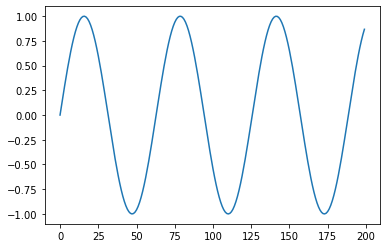

In [3]:
series = np.sin(0.1*np.arange(200))

plt.plot(series)
plt.show()

In [4]:
series

array([ 0.        ,  0.09983342,  0.19866933,  0.29552021,  0.38941834,
        0.47942554,  0.56464247,  0.64421769,  0.71735609,  0.78332691,
        0.84147098,  0.89120736,  0.93203909,  0.96355819,  0.98544973,
        0.99749499,  0.9995736 ,  0.99166481,  0.97384763,  0.94630009,
        0.90929743,  0.86320937,  0.8084964 ,  0.74570521,  0.67546318,
        0.59847214,  0.51550137,  0.42737988,  0.33498815,  0.23924933,
        0.14112001,  0.04158066, -0.05837414, -0.15774569, -0.2555411 ,
       -0.35078323, -0.44252044, -0.52983614, -0.61185789, -0.68776616,
       -0.7568025 , -0.81827711, -0.87157577, -0.91616594, -0.95160207,
       -0.97753012, -0.993691  , -0.99992326, -0.99616461, -0.98245261,
       -0.95892427, -0.92581468, -0.88345466, -0.83226744, -0.77276449,
       -0.70554033, -0.63126664, -0.55068554, -0.46460218, -0.37387666,
       -0.2794155 , -0.1821625 , -0.0830894 ,  0.0168139 ,  0.1165492 ,
        0.21511999,  0.31154136,  0.40484992,  0.49411335,  0.57

In [5]:
T = 10 # Segmentos
X = list()
y = list()

for t in range(len(series) - T): # 190
    
    # Toma valores de X de t en t con stride de 1
    x = series[t : t + T]
    X.append(x)
    
    # Toma los valores de t en t
    y_ = series[t + T]
    y.append(y_)

# Transformamos a np.array y ajustamos las dimensiones
# Para entrar en el modelo debe de tener 3 dimensiones
X = np.array(X).reshape(-1, T, 1)
y = np.array(y)
N = len(X)

print(f"X: {X.shape}\ty: {y.shape}")

X: (190, 10, 1)	y: (190,)


In [6]:
df = pd.DataFrame(data = X[:, :, 0])

df["y"] = y

df

,0,1,2,3,4,5,6,7,8,9,y
0,0.000000,0.099833,0.198669,0.295520,0.389418,0.479426,0.564642,0.644218,0.717356,0.783327,0.841471
1,0.099833,0.198669,0.295520,0.389418,0.479426,0.564642,0.644218,0.717356,0.783327,0.841471,0.891207
2,0.198669,0.295520,0.389418,0.479426,0.564642,0.644218,0.717356,0.783327,0.841471,0.891207,0.932039
3,0.295520,0.389418,0.479426,0.564642,0.644218,0.717356,0.783327,0.841471,0.891207,0.932039,0.963558
4,0.389418,0.479426,0.564642,0.644218,0.717356,0.783327,0.841471,0.891207,0.932039,0.963558,0.985450
...,...,...,...,...,...,...,...,...,...,...,...
185,-0.342481,-0.246974,-0.148999,-0.049536,0.050423,0.149877,0.247834,0.343315,0.435365,0.523066,0.605540
186,-0.246974,-0.148999,-0.049536,0.050423,0.149877,0.247834,0.343315,0.435365,0.523066,0.605540,0.681964
187,-0.148999,-0.049536,0.050423,0.149877,0.247834,0.343315,0.435365,0.523066,0.605540,0.681964,0.751573
188,-0.049536,0.050423,0.149877,0.247834,0.343315,0.435365,0.523066,0.605540,0.681964,0.751573,0.813674


### Model - RNN

In [7]:
model = Sequential()

# Capa de Entrada
model.add(Input(shape = (T, 1)))

# Capas Ocultas
model.add(SimpleRNN(units = 5, activation = "relu"))

# Capa de Salida
model.add(Dense(units = 1))

model.compile(optimizer = "adam", loss = "mse")

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 5)              │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Vamos a cortar los datos a la mitad imitando train_test_split()
# Para un problema de RNN se intentan predecir el siguiente número, no un número en una posición aleatorio
# Por eso no tiene sentido usar train_test_split()

history = model.fit(x = X[:-N//2],
                    y = y[:-N//2],
                    validation_data = (X[-N//2:], y[-N//2:]),
                    epochs = 100)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.2920 - val_loss: 0.4424
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2692 - val_loss: 0.4352
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2853 - val_loss: 0.4280
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2600 - val_loss: 0.4209
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2540 - val_loss: 0.4139
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2619 - val_loss: 0.4070
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2584 - val_loss: 0.4004
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2418 - val_loss: 0.3940
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2825 - val_loss: 0.3877
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2828 - val_loss: 0.3816
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2291 - val_loss: 0.3760
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2420 - val_loss: 0.3704

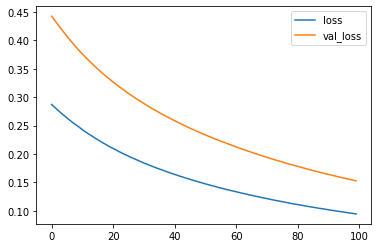

In [9]:
# loss
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.legend()
plt.show()

In [10]:
model.predict(X[-N//2].reshape(1, -1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


array([[-0.2490366]], dtype=float32)

In [11]:
X[-N//2].reshape(1, -1, 1)

array([[[-0.07515112],
        [-0.17432678],
        [-0.27176063],
        [-0.36647913],
        [-0.45753589],
        [-0.54402111],
        [-0.62507065],
        [-0.69987469],
        [-0.76768581],
        [-0.82782647]]])

### Predicciones

In [12]:
# "1 - Step Predictions"

# Toma un valor y predice el siguiente

validation_target = y[-N//2:]
validation_predictions = list()

i = -N//2

while len(validation_predictions) < len(validation_target):
    
    # Predice el siguiente valor de X[i]
    p = model.predict(X[i].reshape(1, -1, 1))[0, 0]
    i += 1
    
    validation_predictions.append(p)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


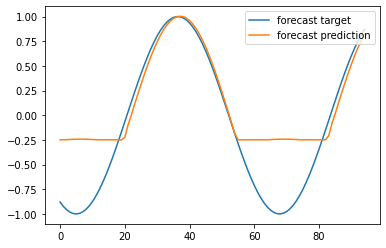

In [13]:
plt.plot(validation_target, label = "forecast target")
plt.plot(validation_predictions, label = "forecast prediction")
plt.legend()
plt.show()

In [14]:
# "Multiple - Step Predictions"

# Toma el último valor de una serie y predice el siguiente
# Usa esa predicción para seguir haciendo predicciones.

validation_target = y[-N//2:]
validation_predictions = list()

last_x = X[-N//2]

while len(validation_predictions) < len(validation_target):
    
    # En la primera iteración predice el siguiente valor de usando X
    # En las siguientes iteraciones usa el valor predicho anterior para predecir el siguiente
    p = model.predict(last_x.reshape(1, -1, 1))[0, 0]
    
    validation_predictions.append(p)
    print(f"Valor: {last_x[-1][0]}\tPredicción: {p}")
    # Desplaza los elementos en last_x hacia atras, dejando el primer elemento al final
    last_x = np.roll(last_x, -1)
    
    # Cambia el último elemento a la predicción
    last_x[-1] = p

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Valor: -0.8278264690856537	Predicción: -0.24903659522533417
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Valor: -0.24903659522533417	Predicción: -0.24903659522533417
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Valor: -0.24903659522533417	Predicción: -0.24903659522533417
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Valor: -0.24903659522533417	Predicción: -0.24903659522533417
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Valor: -0.24903659522533417	Predicción: -0.24903659522533417
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Valor: -0.24903659522533417	Predicción: -0.24903659522533417
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Valor: -0.24903659522533417	Predicción: -0.24903659522533417
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Valor: -0.24903659522533417	Predicción: -0.24903659522533417
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Valor: -0.24903659522533417	Predicción: -0.24903659522533417
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Valor: -0.24903659522533417	Predicción: -0.24903659522533417
1/1 ━━━━━━━━━━━━━━━━

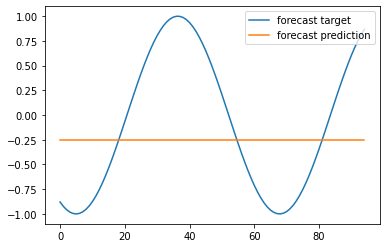

In [15]:
plt.plot(validation_target, label = "forecast target")
plt.plot(validation_predictions, label = "forecast prediction")
plt.legend()
plt.show()

#### Función con ruido

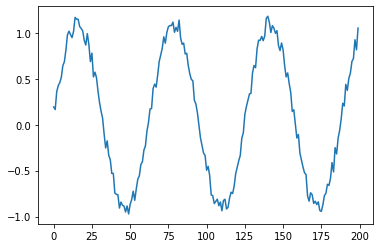

In [16]:
series = np.sin(0.1*np.arange(200)) + np.random.random(200)*0.2

plt.plot(series)
plt.show()

In [17]:
T = 10 # Segmentos
X = list()
y = list()

for t in range(len(series) - T):
    
    # Toma valores de X de t en t con stride de 1
    x = series[t : t + T]
    X.append(x)
    
    # Toma los valores de t en t
    y_ = series[t + T]
    y.append(y_)

# Transformamos a np.array y ajustamos las dimensiones
# Para entrar en el modelo debe de tener 3 dimensiones
X = np.array(X).reshape(-1, T, 1)
y = np.array(y)
N = len(X)

print(f"X: {X.shape}\ty: {y.shape}")

X: (190, 10, 1)	y: (190,)


In [18]:
model = Sequential()

model.add(Input(shape = (T, 1)))
model.add(SimpleRNN(units = 5, activation = "relu"))
model.add(Dense(units = 1))

model.compile(optimizer = "adam", loss = "mse")

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 5)              │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(x = X[:-N//2],
                    y = y[:-N//2],
                    validation_data = (X[-N//2:], y[-N//2:]),
                    epochs = 1000)

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 3.3183 - val_loss: 2.5994
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.2532 - val_loss: 2.5250
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.0168 - val_loss: 2.4550
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9757 - val_loss: 2.3879
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7394 - val_loss: 2.3240
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6765 - val_loss: 2.2632
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6754 - val_loss: 2.2052
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6570 - val_loss: 2.1498
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5898 - val_loss: 2.0971
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4242 - val_loss: 2.0473
Epoch 11/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.2874 - val_loss: 2.0000
Epoch 12/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2419 - val_l

In [ ]:
# loss
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.legend()
plt.show()

In [ ]:
# "1 - Step Predictions"

# Toma un valor y predice el siguiente

validation_target = y[-N//2:]
validation_predictions = list()

i = -N//2

while len(validation_predictions) < len(validation_target):
    
    # Predice el siguiente valor de X[i]
    p = model.predict(X[i].reshape(1, -1, 1))[0, 0]
    i += 1
    
    validation_predictions.append(p)

In [ ]:
plt.plot(validation_target, label = "forecast target")
plt.plot(validation_predictions, label = "forecast prediction")
plt.legend()
plt.show()

In [ ]:
# "Multiple - Step Predictions"

# Toma el último valor de una serie y predice el siguiente
# Usa esa predicción para seguir haciendo predicciones.

validation_target = y[-N//2:]
validation_predictions = list()

last_x = X[-N//2]

while len(validation_predictions) < len(validation_target):
    
    # En la primera iteración predice el siguiente valor de usando X
    # En las siguientes iteraciones usa el valor predicho anterior para predecir el siguiente
    p = model.predict(last_x.reshape(1, -1, 1))[0, 0]
    
    validation_predictions.append(p)
    print(f"Valor: {last_x[-1][0]}\tPredicción: {p}")
    # Desplaza los elementos en last_x hacia atras, dejando el primer elemento al final
    last_x = np.roll(last_x, -1)
    
    # Cambia el último elemento a la predicción
    last_x[-1] = p

In [ ]:
plt.plot(validation_target, label = "forecast target")
plt.plot(validation_predictions, label = "forecast prediction")
plt.legend()
plt.show()

## RNN - MNIST

In [ ]:
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train, X_test = X_train/255.0, X_test/255.0

print(f"Train: {X_train.shape}\tTest: {X_test.shape}")

### Model

In [ ]:
model = Sequential()

model.add(Input(shape = X_train[0].shape))

model.add(SimpleRNN(units = 128, activation = "relu"))

model.add(Dense(units = 10, activation = "softmax"))

model.compile(optimizer = "adam",
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

model.summary()

In [ ]:
history = model.fit(x = X_train,
                    y = y_train,
                    validation_data = (X_test, y_test),
                    epochs = 10)

In [ ]:
# loss
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.legend()
plt.show()

In [ ]:
# accuracy
plt.plot(history.history["accuracy"], label = "accuracy")
plt.plot(history.history["val_accuracy"], label = "val_accuracy")
plt.legend()
plt.show()

In [ ]:
# Predicciones
y_hat = model.predict(X_test)
y_hat = [np.argmax(i) for i in y_hat]

y_hat

In [ ]:
confusion_matrix(y_test, y_hat)

In [ ]:
################################################################################################################################